## Remove Features with low variance

In [1]:
import pandas as pd
from sklearn.feature_selection import VarianceThreshold

In [2]:
df = pd.DataFrame([[1,2,3],[2,3,4],[3,4,5]], columns=["f1","f2","f3"])

In [3]:
df

,f1,f2,f3
0,1,2,3
1,2,3,4
2,3,4,5


In [4]:
var_thresh = VarianceThreshold(threshold=0.1)
transformed_data = var_thresh.fit_transform(df)
transformed_data

array([[1, 2, 3],
       [2, 3, 4],
       [3, 4, 5]])

## Remove Features with High Correlation

In [5]:
import pandas as pd
import numpy as n
from sklearn.datasets import fetch_california_housing

In [6]:
data = fetch_california_housing()
data.data[0:5, :]

array([[ 8.32520000e+00,  4.10000000e+01,  6.98412698e+00,
         1.02380952e+00,  3.22000000e+02,  2.55555556e+00,
         3.78800000e+01, -1.22230000e+02],
       [ 8.30140000e+00,  2.10000000e+01,  6.23813708e+00,
         9.71880492e-01,  2.40100000e+03,  2.10984183e+00,
         3.78600000e+01, -1.22220000e+02],
       [ 7.25740000e+00,  5.20000000e+01,  8.28813559e+00,
         1.07344633e+00,  4.96000000e+02,  2.80225989e+00,
         3.78500000e+01, -1.22240000e+02],
       [ 5.64310000e+00,  5.20000000e+01,  5.81735160e+00,
         1.07305936e+00,  5.58000000e+02,  2.54794521e+00,
         3.78500000e+01, -1.22250000e+02],
       [ 3.84620000e+00,  5.20000000e+01,  6.28185328e+00,
         1.08108108e+00,  5.65000000e+02,  2.18146718e+00,
         3.78500000e+01, -1.22250000e+02]])

In [7]:
X = data.data
col_names = data.feature_names
y=data.target


In [8]:
df = pd.DataFrame(X, columns = col_names)
df["MedInc_Sqrt"] = df["MedInc"].apply(np.sqrt)
df

NameError: name 'np' is not defined

In [ ]:
df.corr()

## Univariate Feature Selection

Three most popular methods
- Mutual Information
- ANOVA F-test
- Chi2 (Note: only for non-negtive data)

## Two ways of using these in scikit-learn 
- SelectKBest: It keeps the top-k scoring features
- SelectPercentile: It keeps the top features which are in a percentage specified by the user

In [9]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectPercentile

In [10]:
class UnivariateFeatureSelection:
    def __init__(self, n_features, problem_type, scoring):
        if problem_type == "classification":
            valid_scoring = {
                "f_classif": f_classif,
                "chi2": chi2,
                "mutual_info_classif": mutual_info_classif
            }
        else:
            valid_scoring = {
                "f_regression": f_regression,
                "mutual_info_regression": mutual_info_regression
            }
        
        if scoring not in valid_scoring:
            raise Exception("Invalid Scoring Function")


        if isinstance(n_features, int):
            self.selection = SelectKBest(
                valid_scoring[scoring],
                k = n_features
            )
        elif isinstance(n_features, float):
            self.selection = SelectPercentile(
                valid_scoring[scoring],
                percentile = int(n_features * 100)
            )   
        else:
            raise Exception("Invalid type of feature")

    
    def fit(self, X, y):
        return self.selection.fit(X, y)

    def transform(self, X):
        return self.selection.transform(X)

    def fit_transform(self, X, y):
        return self.selection.fit_transform(X, y)

            

In [11]:
ufs = UnivariateFeatureSelection(
    n_features=0.1, 
    problem_type="regression",
    scoring="f_regression"
)

ufs.fit(X, y)
X_transformed = ufs.transform(X)

X_transformed

array([[8.3252],
       [8.3014],
       [7.2574],
       ...,
       [1.7   ],
       [1.8672],
       [2.3886]])

## Greedy Feature Selection (GFS)

- step01: choose a model
- step02: select a loss/scoring function
- step03: iteratively evaluate each features and add it to te list of "good" features if it impoves loss/score

In [12]:
import pandas as pd

from sklearn import linear_model
from sklearn import metrics
from sklearn.datasets import make_classification

In [13]:
class GreedyFeatureSelection:
    def evaluate_score(self, X, y):
        model = linear_model.LogisticRegression()
        model.fit(X, y)
        predictions = model.predict_proba(X)[:, 1]
        auc = metrics.roc_auc_score(y, predictions)
        return auc


    def _feature_selection(self, X, y):
        good_features = []
        best_scores = []

        num_features = X.shape[1]

        while True:
            this_feature = None
            best_score = 0

            for feature in range(num_features):
                if feature in good_features:
                    continue

                selected_features = good_features + [feature]
                xtrain=X[:, selected_features]
                score = self.evaluate_score(xtrain, y)
                if score > best_score:
                    this_feature = feature
                    best_score = score
                    
            if this_feature != None:
                good_features.append(this_feature)
                best_scores.append(best_score)

            if len(best_scores) > 2:
                if best_scores[-1] < best_scores[-2]:
                    break

        return best_scores[:-1], good_features[:-1]

    def __call__(self, X, y):
        scores, features = self._feature_selection(X, y)
        return X[:, features], scores            
                    

In [14]:
X, y = make_classification(n_samples=1000, n_features=100)
X.shape

(1000, 100)

In [15]:
y.shape

(1000,)

In [16]:
X_transformed, scores = GreedyFeatureSelection()(X, y)

In [17]:
X_transformed.shape

(1000, 48)

In [52]:
len(scores)

34

## Recursive Feature Elimation (RFE)

 - For SVM/Logistic Regression: Coefficient
 - For Tree-based models: Feature Importance

In [19]:
import pandas as pd

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.datasets import fetch_california_housing

In [20]:
data = fetch_california_housing()
X = data["data"]
col_names = data["feature_names"]
y = data["target"]

In [23]:
model = LinearRegression()

rfe = RFE(
    estimator = model,
    n_features_to_select=3
)

rfe.fit(X, y)

X_transformed = rfe.transform(X)
X_transformed.shape

(20640, 3)

## Select models by feature coefficients/importance of features


Notes:
- If you use coefficients, you can select
a threshold, and if the coefficient is above that threshold, you can keep the feature
else eliminate it.

- You can choose features from one model and use another model to train. For example, you can use Logistic Regression coefficients to select the features and then use Random Forest
to train the model on chosen features.


- Scikit-learn also offers SelectFromModel
class that helps you choose features directly from a given model. You can also specify the threshold for coefficients or feature importance if you want and the maximum number of features you want to select.

In [37]:
## use Random Forest as an example
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor

In [25]:
data = load_diabetes()
X = data['data']
col_names = data.feature_names
y=data['target']

In [27]:
X.shape

(442, 10)

In [29]:
model = RandomForestRegressor()

In [30]:
model.fit(X, y)

RandomForestRegressor()

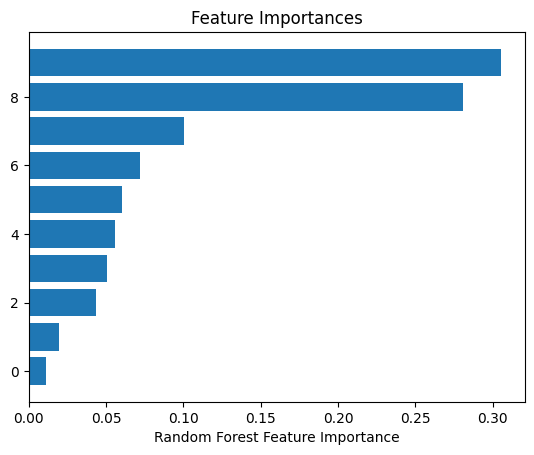

In [38]:
importances = model.feature_importances_
idxs = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.xlabel('Random Forest Feature Importance')
plt.show()

SelectFromModel.

In [39]:
## use Random Forest as an example
import pandas as pd
import numpy as np
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel

In [40]:
data = load_diabetes()
X = data['data']
col_names = data.feature_names
y=data['target']

In [41]:
model = RandomForestRegressor()

In [42]:
# select from the model
sfm = SelectFromModel(estimator=model)
X_transformed = sfm.fit_transform(X, y)

In [43]:
# see which features were selected
support = sfm.get_support()

In [44]:
print([
    x for x, y in zip(col_names, support) if y == True
])

['bmi', 's5']


In [45]:
col_names

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [46]:
support

array([False, False,  True, False, False, False, False, False,  True,
       False])

## Use L1 (Lassso) Penalization for feature selection